# Анализ тарифных планов оператора связи [Яндекс.практикум]

### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


### Задача проекта:
На основе данных клиентов оператора сотовой связи проанализировать поведение клиентов и поиск оптимального тарифа

### Описние проекта:
Проведен предварительный анализ использования тарифов на выборке клиентов, проанализировано поведение клиентов при использовании услуг оператора и рекомендованы оптимальные наборы услуг для пользователей. Проведена предобработка
данных, их анализ. Проверены гипотезы о различии выручки абонентов разных тарифов и различии выручки абонентов из Москвы и других регионов.

# Загрузка и общая информация о данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

try:
    users = pd.read_csv('/datasets/users.csv')
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    users = pd.read_csv('users.csv')
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv', index_col=0)
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')

print(users.info())
print(' ')
print(calls.info())
print(' ')
print(internet.info())
print(' ')
print(messages.info())
print(' ')
print(tariffs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
 
<class 'panda

__Вывод:__
- Данные включают 5 отдельных наборов
- Польльватели могут быть идентифицированы в разных наборов благодаря сквозному `user_id`
- Всего представлена информация о 500 пользователях
- В наборах данных о потребленном количестве минут, смс, интернета представлена информация о звонках / сессиях в течение каждого месяца - отдельными строками, когда пользователель использовал тариф. Для дальнейшей работы необходимо обобщить данные по кользователю и месяцу
- в таблице `internet` есть потенциально ненужный столбец `Unnamed: 0`

# Подготовка данных

## Очистим таблицы, приведем данные к нужным типам

Проверим длительность звонков в минутах, округлим вверх до целого значения

In [2]:
calls['duration']

0          0.00
1          0.00
2          2.85
3         13.80
4          5.18
          ...  
202602     0.76
202603    18.83
202604    10.81
202605     4.27
202606    19.62
Name: duration, Length: 202607, dtype: float64

In [3]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration']  # получили целые значения, округлённые вверх - по правилам тарифа

0          0.0
1          0.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64

Преобразуем столбец с отображением даты звонка, создадим отдельные переменные для месяца в таблицах calls, internet, messages

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [5]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [6]:
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


## Создадим отдельные датафреймы  с объединёнными данными по пользователю и месяцу

Для каждой из таблиц - calls, internet, messages - создадим новую таблицу по user_id и month, просуммируем переменные указывающие на количество использованного трафика в каждой таблице для calls, internet, для messages - посчитаем количество строк id

In [7]:
calls_monthly = calls.groupby(by=['user_id', 'month'])['duration'].sum().reset_index()
internet_monthly = internet.groupby(by=['user_id', 'month'])['mb_used'].sum().reset_index()
messages_monthly = messages.groupby(by=['user_id', 'month'])['id'].count().reset_index()
messages_monthly.columns = ['user_id', 'month', 'messages_number'] # Заменим название столбца на более содержательное

# проверим содержние новых таблиц
display(calls_monthly.head(3))
display(internet_monthly.head(3))
messages_monthly.head(3)

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0


,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64


,user_id,month,messages_number
0,1000,5,22
1,1000,6,60
2,1000,7,75


В соответствии с тарифом количество использованных мегабайтов за месяц округляется до гигабайта, скорректируем данные в соответствии с требованиями тарифа в таблице internet_monthly

In [8]:
internet_monthly['mb_used'].describe()

count     3203.000000
mean     17266.708626
std       7516.356902
min          0.000000
25%      12526.905000
50%      16963.110000
75%      21432.175000
max      49745.690000
Name: mb_used, dtype: float64

In [9]:
internet_monthly['gb_used'] = np.ceil(internet_monthly['mb_used']/ 1024) * 1024
internet_monthly.sort_values(by='mb_used') # округление вверх проведено корректно до ближайшего гигабайта

,user_id,month,mb_used,gb_used
592,1094,5,0.00,0.0
2298,1365,10,0.00,0.0
3102,1482,2,201.07,1024.0
1290,1201,12,365.09,1024.0
667,1105,9,370.06,1024.0
...,...,...,...,...
383,1060,12,43931.36,44032.0
1901,1300,11,44296.86,45056.0
1622,1255,7,45180.71,46080.0
1524,1240,8,48351.59,49152.0


In [10]:
internet_monthly = internet_monthly.drop(columns='mb_used', axis=1)
# удалим колонку с мегабайтами трафика, поскольку она не нужна для объединения

Отсортируем данные в таблицах internet_monthly, messages_monthly, calls_monthly по идентификатору пользователя и месяцу

In [11]:
internet_monthly = internet_monthly.sort_values(by=['user_id', 'month'])
messages_monthly = messages_monthly.sort_values(by=['user_id', 'month'])
calls_monthly = calls_monthly.sort_values(by=['user_id', 'month'])
# Проверим сортировку в одной из таблиц
calls_monthly[calls_monthly['user_id'] < 1004] # данные отсортированы по идентификатору пользовател и месяцу

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0
5,1000,10,350.0
6,1000,11,338.0
7,1000,12,333.0
8,1001,11,430.0
9,1001,12,414.0


## Объединеним данные об объёмах использованного трафика - звонки, интернет собщения в месяц - в один датафрейм

In [12]:
#объединяет помесячные данные calls_monthly, internet_monthly, messages_monthly Через how='outer' для сохранения всех данных

users_monthly_data = pd.DataFrame(calls_monthly.merge(internet_monthly, on = ['user_id', 'month'], how='outer'))
users_monthly_data = users_monthly_data.merge(messages_monthly, on = ['user_id', 'month'], how='outer')
users_monthly_data[users_monthly_data['user_id'] < 1005] # провери как объединились данные

,user_id,month,duration,gb_used,messages_number
0,1000,5,159.0,3072.0,22.0
1,1000,6,172.0,23552.0,60.0
2,1000,7,340.0,14336.0,75.0
3,1000,8,408.0,14336.0,81.0
4,1000,9,466.0,15360.0,57.0
5,1000,10,350.0,15360.0,73.0
6,1000,11,338.0,15360.0,58.0
7,1000,12,333.0,10240.0,70.0
8,1001,11,430.0,18432.0,NaN
9,1001,12,414.0,14336.0,NaN


In [13]:
users_monthly_data.info() 
# в процессе преобразования данные по столбцам duration, gb_used, messages_number преобразовались в тип float
#вероято потому, что в столбцах при объединении появились Nan


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3214 non-null   int64  
 1   month            3214 non-null   int64  
 2   duration         3174 non-null   float64
 3   gb_used          3203 non-null   float64
 4   messages_number  2717 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.7 KB


После объединения таблиц общее колчество строк стало - 3214.   

При этом все колонки, кроме `user_id` и `month` содержат пропуски:
    - duration - 40 строк
    - gb_used - 11 строк
    - messages_number - 497 строк

In [14]:
users_monthly_data[users_monthly_data['gb_used'].isna()]

,user_id,month,duration,gb_used,messages_number
1697,1273,5,220.0,NaN,21.0
1698,1273,6,230.0,NaN,38.0
1699,1273,7,253.0,NaN,37.0
1700,1273,8,253.0,NaN,41.0
1701,1273,9,223.0,NaN,32.0
1702,1273,10,315.0,NaN,35.0
1703,1273,11,272.0,NaN,29.0
1704,1273,12,260.0,NaN,39.0
2358,1377,2,179.0,NaN,2.0
2471,1392,2,13.0,NaN,3.0


In [15]:
users_monthly_data[users_monthly_data['duration'].isna()]

,user_id,month,duration,gb_used,messages_number
3174,1091,5,NaN,11264.0,30.0
3175,1091,6,NaN,10240.0,30.0
3176,1091,7,NaN,17408.0,35.0
3177,1091,8,NaN,13312.0,31.0
3178,1091,9,NaN,17408.0,32.0
3179,1091,10,NaN,16384.0,44.0
3180,1091,11,NaN,12288.0,28.0
3181,1091,12,NaN,13312.0,42.0
3182,1106,4,NaN,3072.0,9.0
3183,1106,5,NaN,17408.0,28.0


Считаю, что пропуски в данных в этом случае могут означать - не использование услуги в каком-то месяце. Эту гипотезу подтверждает большее число пропусков для сообщений - которые действительно стали реже использоваться после появления мессенджеров.

Абоненты, у которых NaN в столбце продолжитльности звонков - вычерпывали много трафика. Вероятно, использовали для звонков интернет.
У большинства пользователей, которые не используют интернет - выраженное использование звонков и смс.

В связи с этим считаю уместным заполнить пропуски нулевыми значениями.   

Замена NAN на нулевое значение допустима в данном случае в связи с логикой данных. Если Nan несут другой смысл - лучше заменить медианой, поскольку нулевые значения могут смещать выборку

In [16]:
users_monthly_data['duration'] = users_monthly_data['duration'].fillna(0)
users_monthly_data['gb_used'] = users_monthly_data['gb_used'].fillna(0)
users_monthly_data['messages_number'] = users_monthly_data['messages_number'].fillna(0)

In [17]:
users_monthly_data.info() # пропуски заполнены

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3214 non-null   int64  
 1   month            3214 non-null   int64  
 2   duration         3214 non-null   float64
 3   gb_used          3214 non-null   float64
 4   messages_number  3214 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.7 KB


## Объединеним данные об объёме трафика с информацеий о пользователях и тарифе

In [18]:
users # Посмотрим на данные в таблице users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [19]:
users_monthly_data = users_monthly_data.merge(users, on = ['user_id'], how='inner')

In [20]:
users_monthly_data


,user_id,month,duration,gb_used,messages_number,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,3072.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,23552.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,14336.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,14336.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,15360.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,11264.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3210,1489,9,0.0,17408.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3211,1489,10,0.0,20480.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,11,0.0,18432.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [21]:
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [22]:
users_monthly_data = users_monthly_data.merge(tariffs, on = ['tariff'], how='inner')
users_monthly_data

,user_id,month,duration,gb_used,messages_number,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,3072.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,23552.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,14336.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,14336.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,15360.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,11264.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,9,0.0,17408.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,10,0.0,20480.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,11,0.0,18432.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3


In [23]:
users_monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   duration               3214 non-null   float64
 3   gb_used                3214 non-null   float64
 4   messages_number        3214 non-null   float64
 5   age                    3214 non-null   int64  
 6   churn_date             187 non-null    object 
 7   city                   3214 non-null   object 
 8   first_name             3214 non-null   object 
 9   last_name              3214 non-null   object 
 10  reg_date               3214 non-null   object 
 11  tariff                 3214 non-null   object 
 12  messages_included      3214 non-null   int64  
 13  mb_per_month_included  3214 non-null   int64  
 14  minutes_included       3214 non-null   int64  
 15  rub_

## Рассчитаем выручку для каждого пользователя за каждый месяц использования тарифа

Расчет выручки будем проводить с помощью функции `income_user_per_month`

Инструкция по расчёту:  
Вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану

In [24]:
# прощу посчитать помесячную выручку и добавить в данные

def income_user_per_month(row):
    income_user_ultra = 0
    income_user_smart = 0
    
    if row['tariff']== 'ultra':
        income_user_ultra += 1950
        if row['duration'] > 3000:
            min_overlimit_cost = (row['duration'] - 3000) * 1
            income_user_ultra += min_overlimit_cost
        if row['gb_used'] > 30720:
            gb_overlimit_cost = (np.ceil((row['gb_used'] - 30720)/ 1024)) * 150
            income_user_ultra += gb_overlimit_cost
        if row['messages_number'] > 1000:
            msg_overlimit_cost = (row['messages_number'] - 1000) * 1
            income_user_ultra += msg_overlimit_cost
        return income_user_ultra
    
    elif row['tariff'] == 'smart':
        income_user_smart += 550
        
        if row['duration'] > 500:
            min_overlimit_cost = (row['duration'] - 500) * 3
            income_user_smart += min_overlimit_cost
            
        if row['gb_used'] > 15360:
            gb_overlimit_cost = (np.ceil((row['gb_used'] - 15360)/ 1024)) * 200
            income_user_smart += gb_overlimit_cost
            
        if row['messages_number'] > 50:
            msg_overlimit_cost = (row['messages_number'] - 50) * 3
            income_user_smart += msg_overlimit_cost
            
    return income_user_smart

In [25]:
# применим функцию к датафрейму
users_monthly_data['income_user_per_month'] = users_monthly_data.apply(income_user_per_month, axis=1)

__Вывод:__

Получилось объединить данные о ежемесячном потреблении трафика абонентами (на основании user_id) с данными абонентов и информацией о тарифе абонента

1. Проведена предобработка данных для объединения:
    - удален столбец из таблицы internet
    - данные о длительности звонков объединены до полной минуты
    
             
2. Таблицы calls, internet, messages сгруппированы по идентификационному номеру аббонента и месяцу оказания услуги, данные отсортированы по индетификатору абонента и месяцу. В таблице internet затраченные за месяц мегайбайты округлены до следующего гигабайта, столбец с данными об исходных затратах в мегабайтах удален перед объединением в другими таблицами


3. Таблицы calls, internet, messages содержали разное количество строк, то есть для отдельных абонентов отсутствуют данные по тем или иным видам услуг, которыми они, возможно, не пользовались в данном периоде или вообще. Для объединения таблиц использовалась функция merge с признаком how='outer', чтобы сохранились все данные из объединяемых таблиц. В результате получена таблица `users_monthly_data`, с данными о продолжительности звонков за месяц, количестве смс и гигабайтах интернета. Полученные пропуски заменены на нулевые значения.


4. К полученной таблице на основании user_id с помощью функции merge и c признаком how='inner' добавлены данные о пользователях из таблицы users. К полученной таблице на основании данных столбца tariff к каждой строке добавлены данные о требованиях тарифа.


5. Рассчитана и добавлена переменная - помесячная выручка на клиента (income_user_per_month)


# Проанализуем данные об абонентах

Опишите поведение клиентов оператора, исходя из выборки. 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитайте среднее количество, дисперсию и стандартное отклонение. 
- Постройте гистограммы. Опишите распределения.

## Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Посмотрим на значения среднего и медианы для пользователей двух тарифов по продолжительности звонков, объёму интернет трафика, количеству смс и затратам в месяц

In [26]:
# Среднее по тарифам
users_monthly_data.pivot_table(index=['tariff'], 
                               values = ['duration', 'gb_used', 'messages_number', 'income_user_per_month'],  
                               aggfunc='mean')

,duration,gb_used,income_user_per_month,messages_number
tariff,,,,
smart,417.934948,16720.739345,1289.973531,33.384029
ultra,526.623350,19962.282234,2070.152284,49.363452


In [27]:
# медиана по тарифам
users_monthly_data.pivot_table(index=['tariff'], 
                               values = ['duration', 'gb_used', 'messages_number', 'income_user_per_month'],  
                               aggfunc='median')

,duration,gb_used,income_user_per_month,messages_number
tariff,,,,
smart,422.0,17408.0,1023.0,28.0
ultra,518.0,19456.0,1950.0,38.0


__Выводы:__

В среднем пользователи тарифа 'ultra':
- дольше говорят по телефону
- используют больший объем трафика
- отправляют больше сообщений

При этом в среднем потребление трафика для пользователей двух тарифов ближе, чем различия по количеству предоставляемых минут, магабайтов и интернет трафика в тарифах

Пользователи 'Ultra' - на основании средних значений - тратят существенно меньше минут, гигабайт и смс, чем заложено в тарифе:
- 53% от минут в тарифе
- 66% от объема интернет трафика
- 5 % от количества смс в тарифе

Пользователи 'Smart' - на основании средних значений - тратят больший процент траифка в соотношении с тарифом:
- 83% от минут в тарифе
- 108% от объёма интернет трафика в тарифе (используют больше, чем заложено)
- 66% от количества смс в тарифе


Интересные наблюдения при анализе средних значений:
- В среднем пользователи тарифа 'smart' используют больше трафика, чем заложено тарифом, а пользователи тарифа 'ultra' в среднем тратят меньше, чем заложено в тарифе

- В среднем затраты пользователя по тарифу 'smart' на 134 % превышают стоимость тарифа, для тарифа ультра средние ежемесячные затраты пользователя превыщают тарифную ставку на 7%


## Проанализируем среднее количество, дисперсию и стандартное отклонение объёма трафика и средних месячных затрат для абонентов каждого тарифа отдельно

In [28]:
tariff_users = users_monthly_data.pivot_table(index=['user_id', 'tariff'],
                              values = ['age'],  
                               aggfunc='count').reset_index()
tariff_users['tariff'].value_counts() # количество пользователей каждого тарифа в данных

smart    350
ultra    148
Name: tariff, dtype: int64

In [29]:
# Пользователи тарифа "Смарт"
smart_user_mean = users_monthly_data.query('tariff == "smart" ').pivot_table(index=['user_id'], 
                               values = ['duration', 'gb_used', 'messages_number', 'income_user_per_month'],  
                               aggfunc='mean')

smart_user_mean.describe()

,duration,gb_used,income_user_per_month,messages_number
count,350.000000,350.000000,350.000000,350.000000
mean,419.634803,16699.923315,1324.401019,32.352078
std,145.031543,3585.682360,606.040551,26.512448
min,0.000000,5864.727273,550.000000,0.000000
25%,316.886364,14336.000000,867.550000,11.000000
50%,425.062500,16725.333333,1177.116667,27.750000
75%,519.508333,19140.266667,1667.250000,48.000000
max,891.500000,27904.000000,4333.333333,118.000000


In [30]:
# Пользователи тарифа "Ультра"
ultra_user_mean = users_monthly_data.query('tariff == "ultra" ').pivot_table(index=['user_id'], 
                               values = ['duration', 'gb_used', 'messages_number', 'income_user_per_month'],  
                               aggfunc='mean')
ultra_user_mean.describe()

,duration,gb_used,income_user_per_month,messages_number
count,148.000000,148.000000,148.000000,148.000000
mean,527.821819,20058.568948,2086.464659,54.030743
std,281.786359,8310.906770,298.532720,46.366246
min,0.000000,0.000000,1950.000000,0.000000
25%,325.437500,15080.727273,1950.000000,17.000000
50%,514.541667,19225.600000,1950.000000,45.500000
75%,746.972222,26304.000000,1990.625000,84.250000
max,1179.363636,39424.000000,3225.000000,192.000000


__Выводы:__

1. В выборке более чем в два раза выше количество пользователей тарифа Smart(350), чем тарифа Ultra(148). Возникает вопрос о том, повторяет ли эта подвыборка пропорции генеральной совокупности оператора "Мегалайн". Это было бы логично, поскольку далеко не всем абонентая необходим объём услуг, которые предполагает тариы Ultra


2. Стандартное отклонение по среднемесячной выручке выше для пользователей тарифа Smart - пользователи этот тарифа сильнее отличаются между собой по ежемесячной плате за услуги оператору связи, чем пользователи тарифа 'Ultra'


3. По продолжительности звонков и использованного интернет трафика, количеству смс:
      - В тарифе Ultra выше среднее и медиана и больше стандартное отклонение. Абоненты тарифа Ultra больше отличаются между собой по количеству использованный минут и мегабайт, чем пользователи тарифа Smart
      
      
      
4. Максимальная стоимость услуг выше для одного из пользователей тарифа Smart.




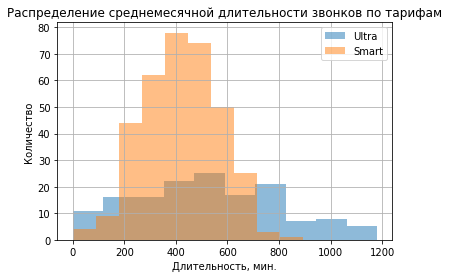

In [31]:
ultra_user_mean['duration'].hist(alpha = 0.5, label='Ultra')  # синий
smart_user_mean['duration'].hist(alpha = 0.5, label='Smart') # оранжевый

plt.title('Распределение среднемесячной длительности звонков по тарифам')
plt.xlabel('Длительность, мин.')
plt.ylabel('Количество')
plt.legend()
plt.show()

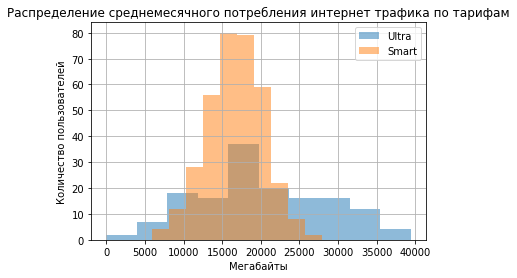

In [32]:
ultra_user_mean['gb_used'].hist(alpha = 0.5, label='Ultra') # синий
smart_user_mean['gb_used'].hist(alpha = 0.5, label='Smart')  # оранжевый

plt.title('Распределение среднемесячного потребления интернет трафика по тарифам')
plt.xlabel('Мегабайты')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

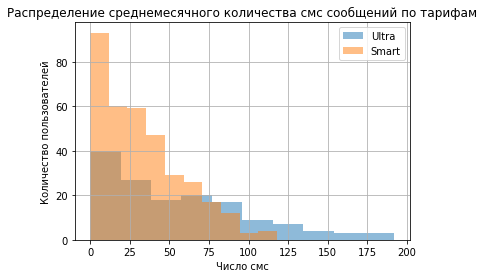

In [33]:
ultra_user_mean['messages_number'].hist(alpha = 0.5, label='Ultra') # синий
smart_user_mean['messages_number'].hist(alpha = 0.5, label='Smart')# оранжевый

plt.title('Распределение среднемесячного количества смс сообщений по тарифам')
plt.xlabel('Число смс')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

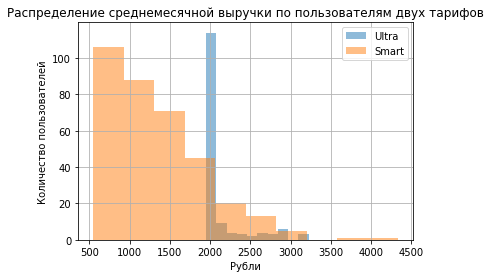

In [34]:
ultra_user_mean['income_user_per_month'].hist(alpha = 0.5, label='Ultra') # синий
smart_user_mean['income_user_per_month'].hist(alpha = 0.5, label='Smart') # оранжевый

plt.title('Распределение среднемесячной выручки по пользователям двух тарифов')
plt.xlabel('Рубли')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

__Комментарии:__

Пользователи тарифа 'smart' используют в среднем меньше трафика, чем пользователи тарифа 'ultra'.

Гистограмма потребления услуг для абонентов тарифа Smart больше соответствует нормальному распределению по продолжтиельности звонков и интернет трафику.

Для пользователей тарифа Smart количество использованных сообщений имеет пик в диапазоне от 0 до 40. График использования смс среди пользователей тарифа Ultra ближе к равномерному распределению

Часть пользователей тарифа Smart оплачивают только абонтсткую плату, многие платят больше.

Почти все пользователи тарифа Ultra платят только абонентскую плату, редкие пользователи платят больше

## Проанализируем данные о пользователях двух тарифов

Распределение клиентов двух тарифов по возрасту очень близки

In [35]:
users_monthly_data.query('tariff == "smart" ').pivot_table(index=['user_id'], 
                               values = ['age'],  
                               aggfunc='mean').describe()

,age
count,350.000000
mean,46.445714
std,16.602937
min,18.000000
25%,32.000000
50%,46.500000
75%,62.000000
max,75.000000


In [36]:
users_monthly_data.query('tariff != "smart" ').pivot_table(index=['user_id'], 
                               values = ['age'],  
                               aggfunc='mean').describe()

,age
count,148.000000
mean,46.871622
std,16.977889
min,18.000000
25%,31.000000
50%,46.000000
75%,63.000000
max,75.000000


Рассмотрим распределение пользователей по городам.   
Больше всего уникальных пользователей из Москвы и Санкт-Петербурга.  
Почти 20% уникальных пользователей в данных - из Москвы  

In [37]:
users['city'].value_counts().head(20)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Набережные Челны    11
Екатеринбург        11
Краснодар           11
Ульяновск           11
Челябинск            9
Самара               9
Волгоград            8
Пермь                8
Нижний Новгород      8
Красноярск           7
Улан-Удэ             7
Вологда              7
Новокузнецк          7
Киров                6
Name: city, dtype: int64

# Проверим статистически гипотезы

## Проверка гипотезы о средней выручке пользователей тарифов  «Ультра» и «Смарт» 

**Нулевая гипотеза** - Средняя ежемесячная выручка по пользователям тарифов «Ультра» и «Смарт» равны

**Альтернативная гипотеза** - Средняя ежемесячная выручка по пользователям тарифов «Ультра» и «Смарт» различается

Выборки пользователей являются независимыми. При этом отличаются дисперсии. Будем использовать двухстороннюю гипотезу, с уровнем значимости 5% и парамтером equal_var=False

In [38]:
# проведем сравнение данных по усреднённому датасету по пользователем

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    ultra_user_mean['income_user_per_month'], 
    smart_user_mean['income_user_per_month'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.0849618995835953e-59
Отвергаем нулевую гипотезу


In [39]:
# проведем сравнение на исходных данных
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу


results = st.ttest_ind(
    users_monthly_data.query('tariff == "ultra"')['income_user_per_month'], 
    users_monthly_data.query('tariff != "ultra"')['income_user_per_month'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


__Вывод:__

**Нулевая гипотеза о равенстве средних по ежемесячной выручке по тарифам «Ультра» и «Смарт» отвергается.**   
Принимается альтернативная гипотеза - Средняя ежемесячная выручка по пользователям тарифов «Ультра» и «Смарт» различается.
    
    
Средняя ежемесяная выручка выше для пользователей тарифа Ultra

### Ещё один вариант гипотезы - о совокупной выручке на пользователя

**Нулевая гипотеза** - Совокупная выручка по пользователям тарифов «Ультра» и «Смарт» равны   
**Альтернативная гипотеза** - Совокупная выручка по пользователям тарифов «Ультра» и «Смарт» различается

Выборки пользователей являются независимыми. При этом отличаются дисперсии. Будем использовать двухстороннюю гипотезу, с уровнем значимости 5%

In [40]:
# Пользователи тарифа "Смарт"
smart_user_sum = users_monthly_data.query('tariff == "smart" ').pivot_table(index=['user_id'], 
                               values = ['income_user_per_month'],  
                               aggfunc='sum')
ultra_user_sum = users_monthly_data.query('tariff != "smart" ').pivot_table(index=['user_id'], 
                               values = ['income_user_per_month'],  
                               aggfunc='sum')


Распределение совокупных затрат по пользователям:

- для тарифа Smart - пик в диапазоне до 12 000 рублей
- для тарифа Ultra - более равномерное распределение до 24 тыс рублей

<AxesSubplot:>

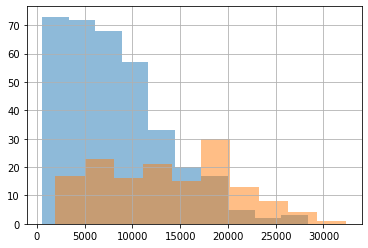

In [41]:
smart_user_sum['income_user_per_month'].hist(alpha=0.5)
ultra_user_sum['income_user_per_month'].hist(alpha=0.5)

In [42]:
# проведем сравнение данных по усреднённому датасету по пользователем

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    ultra_user_sum['income_user_per_month'], 
    smart_user_sum['income_user_per_month'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.1988922393814165e-16
Отвергаем нулевую гипотезу


__Вывод:__

**Нулевая гипотеза о равенстве совокупной выручки на абонента по тарифам «Ультра» и «Смарт» отвергается.**   
Принимается альтернативная гипотеза - Совокупная выручка по пользователям тарифов «Ультра» и «Смарт» различается.
    
    
Средняя ежемесяная выручка выше для пользователей тарифа Ultra

__Вывод по подразделу:__
    
Среднемесячная и совокупная выручка пользователей тарифа «Ультра» значимо выше, чем среднемесячная выручка тарифа "Смарт"

# Общий вывод

1. Проведена подготовка данных для анализа:
    - удален лишний столбец (таблица internet)
    - в таблицах по количеству минут, количеству смс, интернет трафику создана переменная месяц из даты
    - на основании уникального user_id и месяца интегрированы данные по объёму использованных услуг в таблицах calls, messages, internet
    - аггрегированные данные объединены в одну таблицу
    - к аггрегированной таблице добавлены данные о пользователях и тарифе каждого пользователя
    - проведен расчёт выручки по каждому пользователю в каждом месяце
    
    
2. Проведено сравнение пользователей двух тарифов по количеству минут разговора, сообщений и интернет-трафику в месяц.
    - в данных представлено разное количество пользователей для каждого тарифа
    - в среднем пользователи тарифа 'Ultra' тратят больше минут, смс и интернет трафика
    - при сопоставлении трат пользователей и объёмов тарифа - пользователи тарифа 'Ultra' тратят существенно меньше минут, гигабайт и смс, чем заложено в тарифе. А пользователи тарифа 'Smart' тратят в больший процент трафика в соотношении с тарифом, часто выходят за объём тарифа в части интернет трафика.
    - в среднем затраты пользователя по тарифу 'smart' на 140 % превышают стоимость тарифа, для тарифа ультра средние ежемесячные затраты пользователя превыщают тарифную ставку на 7%
    

3. На основании анализа дисперсии по потребляемым услугам для абонентов из разных тарифов, сделан вывод, что абоненты тарифа Ultra больше отличаются между собой по количеству использованных минут и мегабайт, чем пользователи тарифа Smart.


4. Абоненты тарифа 'Smart' сильнее различаются между собой по сумме ежемесячного платежа


5. Статистически подтверждено, что средняя месячная выручка по пользователям тарифов «Ультра» и «Смарт» различается, выручка выше для пользователей тарифа 'Ultra'


**"Лучший тариф"**


На основании проведённого анализа мне сложно сделать вывод, какой тариф лучше. Поскольку тариф может быть "лучше" для разной задачи. Лучший тариф для Компании и для разных пользователей - может быть разным


Наблюдение 1:
- для тарифа 'Ultra' выше среднемесячные платежи за счет стоимости самого тарифа

- пользователи тарифа 'Smart' чаще доплачивают за дополнительные минуты и интернет трафик. 
При этом пользователей тарифа 'Smart' больше, чем пользователей тарифа 'Ultra', допустима гипотеза, что на генеральной совокупности пользователи тарифа 'Smart' приносят больший доход компании.


Наблюдение 2.
- для увеличения выручки от тарифа  'Smart' может быть полезным поднять стоимость дополнительных минут и гигабайтов
- для увеличения выручки от 'Ultra' может быть полезным поднять ежемесячный платеж

Всегда есть риск, что пользователь решит перейти к другому оператору с более подходящим ценнобразованием под его/ её потребности


Наблюдение 3.
- пользователи тарифа ультра тратят в среднем меньше, чем заложено в тариф, значит могут быть чуть выгоднее для Компании, которая фактически оказывает меньше услуг, чем оплачено пользователем. При этом среди них есть те, кто использует существенно больше трафика.
- Некоторые пользователи тарифа 'Smart' платят больше, чем пользователи тарифа 'Ultra' - возможно данным пользователям стоит предложить другой тариф

